In [1]:
import numpy as np

from matplotlib.ticker import (
    AutoMinorLocator, 
    MultipleLocator,
)

def histogram_to_probabilities_of_deviation(hist, a=5.5, precision=0.01):
    res = np.zeros(hist.shape)
    total = sum(hist.T[0])    # equal to the number of iterations
    h = hist.shape[0]
    a = int(a / precision)
    up = h - a > a
    upper_bound = h - a if up else a
    
    for j, col in enumerate(hist.T):
        s = total - col[a]
        res[a][j] = 1.0
        for i in range(1, upper_bound):
            p = s / total
            u = a + i < h
            d = a - i >= 0
            s -= (col[a + i] if u else 0) + (col[a - i] if d else 0)
            if u:
                res[a + i][j] = p
            if d:
                res[a - i][j] = p
    
    return res


def setup_axis(
    ax, xlim, ylim,
    xlabel="days",
    ylabel="average",
    figsize=(40, 20),
    labels_font_size=24,
    ticks_font_size=20,
    x_major_ticks=100,
    x_minor_ticks=4,
    y_major_ticks=5,
    y_minor_ticks=5,
    major_line_width=0.75,
    minor_line_width=0.25,
    text_color="white",
):
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    ax.set_xlabel(xlabel, fontsize=labels_font_size, color=text_color)
    ax.set_ylabel(ylabel, fontsize=labels_font_size, color=text_color)
    
    ax.tick_params(axis="both", labelsize=ticks_font_size, labelcolor=text_color)

    ax.xaxis.set_major_locator(MultipleLocator(x_major_ticks))
    ax.xaxis.set_minor_locator(AutoMinorLocator(x_minor_ticks))
    ax.yaxis.set_major_locator(MultipleLocator(y_major_ticks))
    ax.yaxis.set_minor_locator(AutoMinorLocator(y_minor_ticks))

    ax.grid(which="major", axis="both", linestyle="-", linewidth=major_line_width)
    ax.grid(which="minor", axis="both", linestyle="-", linewidth=minor_line_width)
    

def setup_colorbar(fig, im, ax, plt, text_color="white", label="probability, log10"):
    cb = fig.colorbar(im, ax=ax)
    cb.set_label(label)
    cb.ax.yaxis.set_tick_params(color=text_color)
    plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color=text_color)

    
def plot_data(ax, data, days, precision, cmap):
    return ax.pcolormesh(
        np.arange(0, days, 1),
        np.arange(0, 12 + precision, precision), 
        data, 
        vmin=data.min(), vmax=data.max(),
        cmap=cmap,
    #     norm=norm, 
        shading="auto",
    )

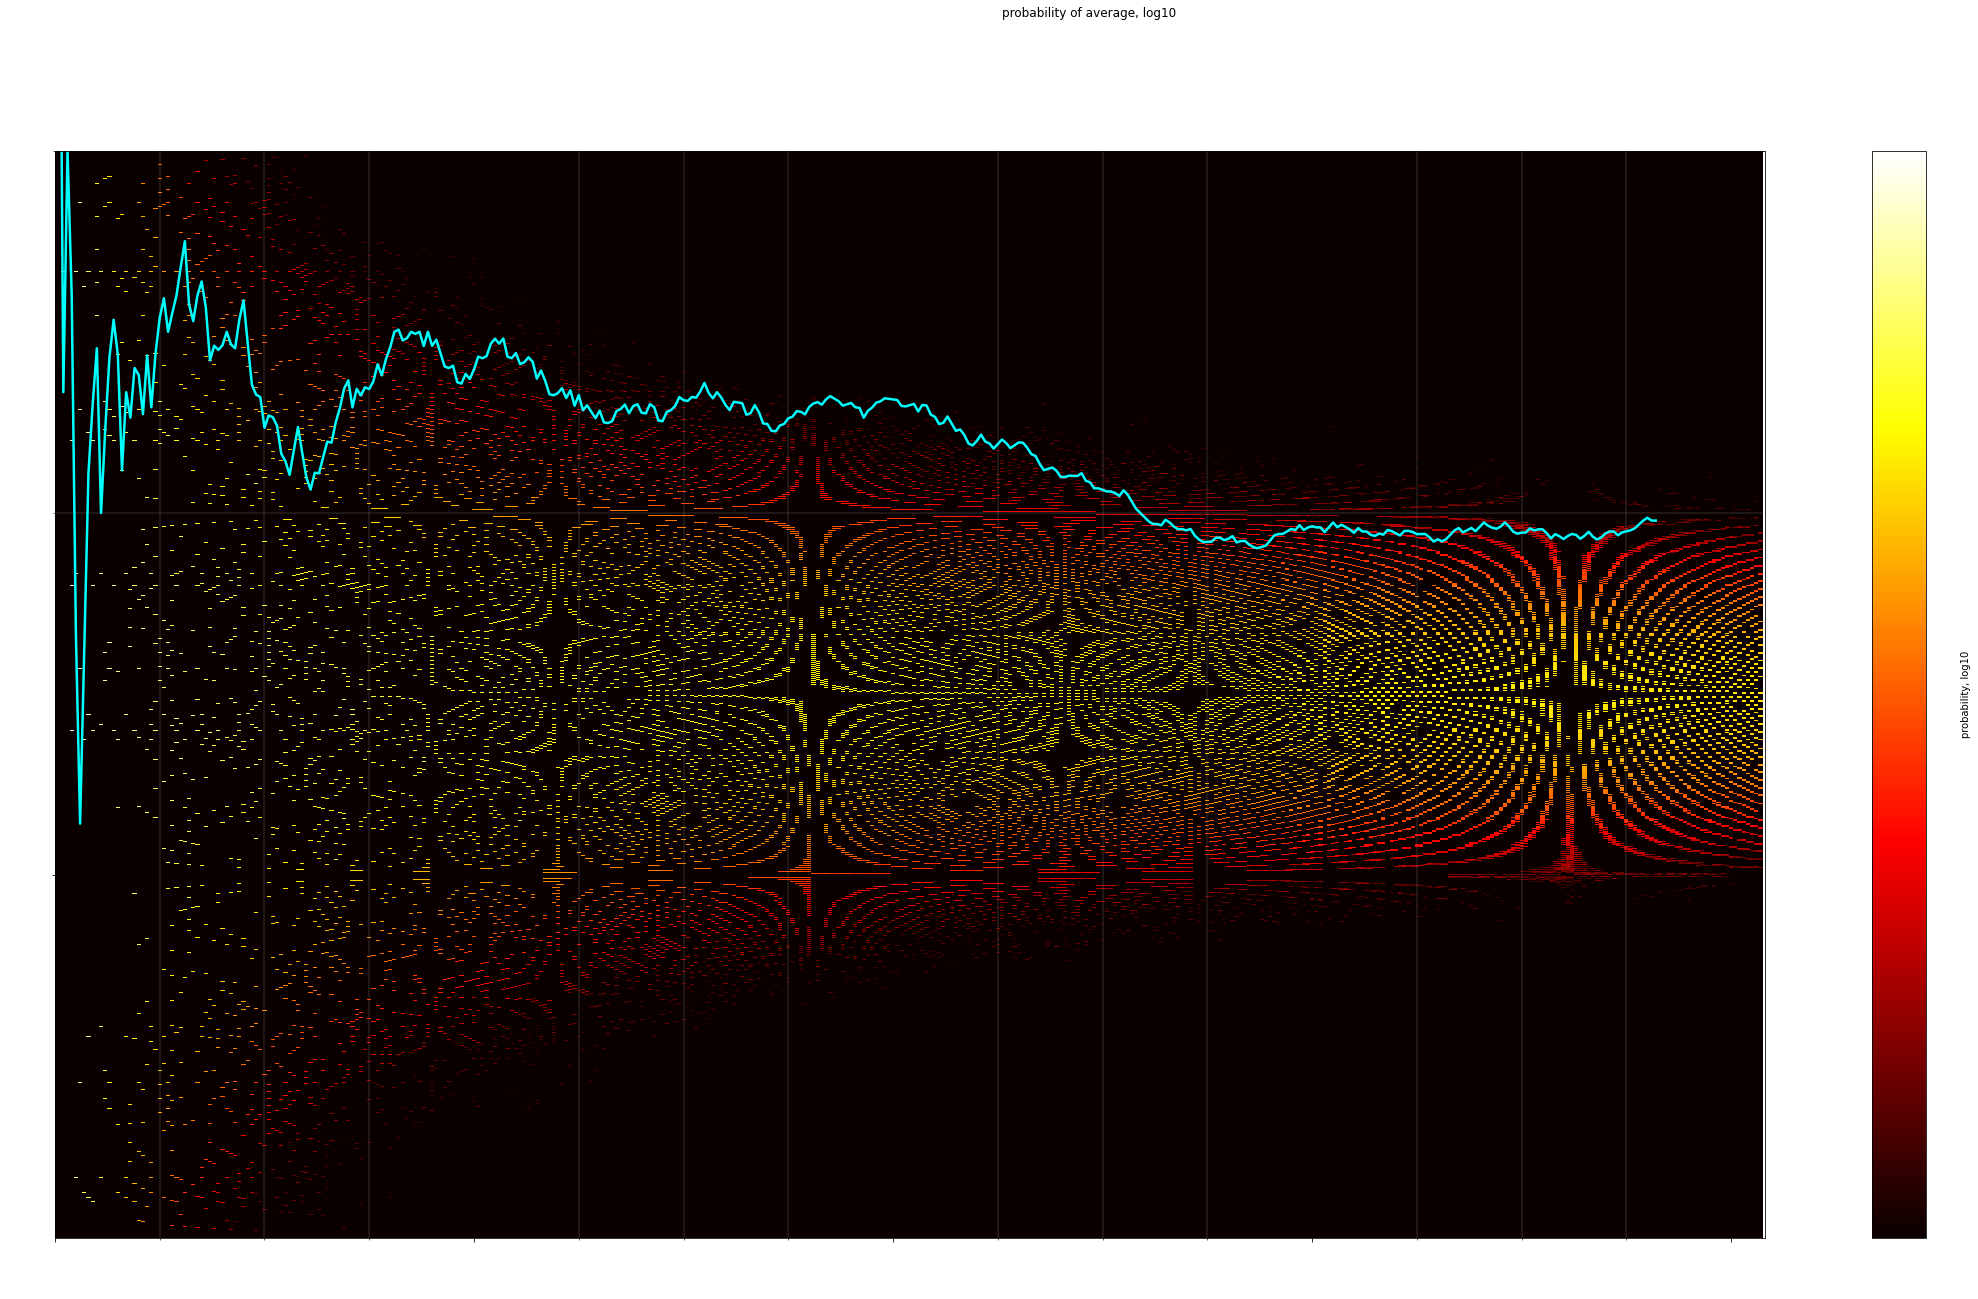

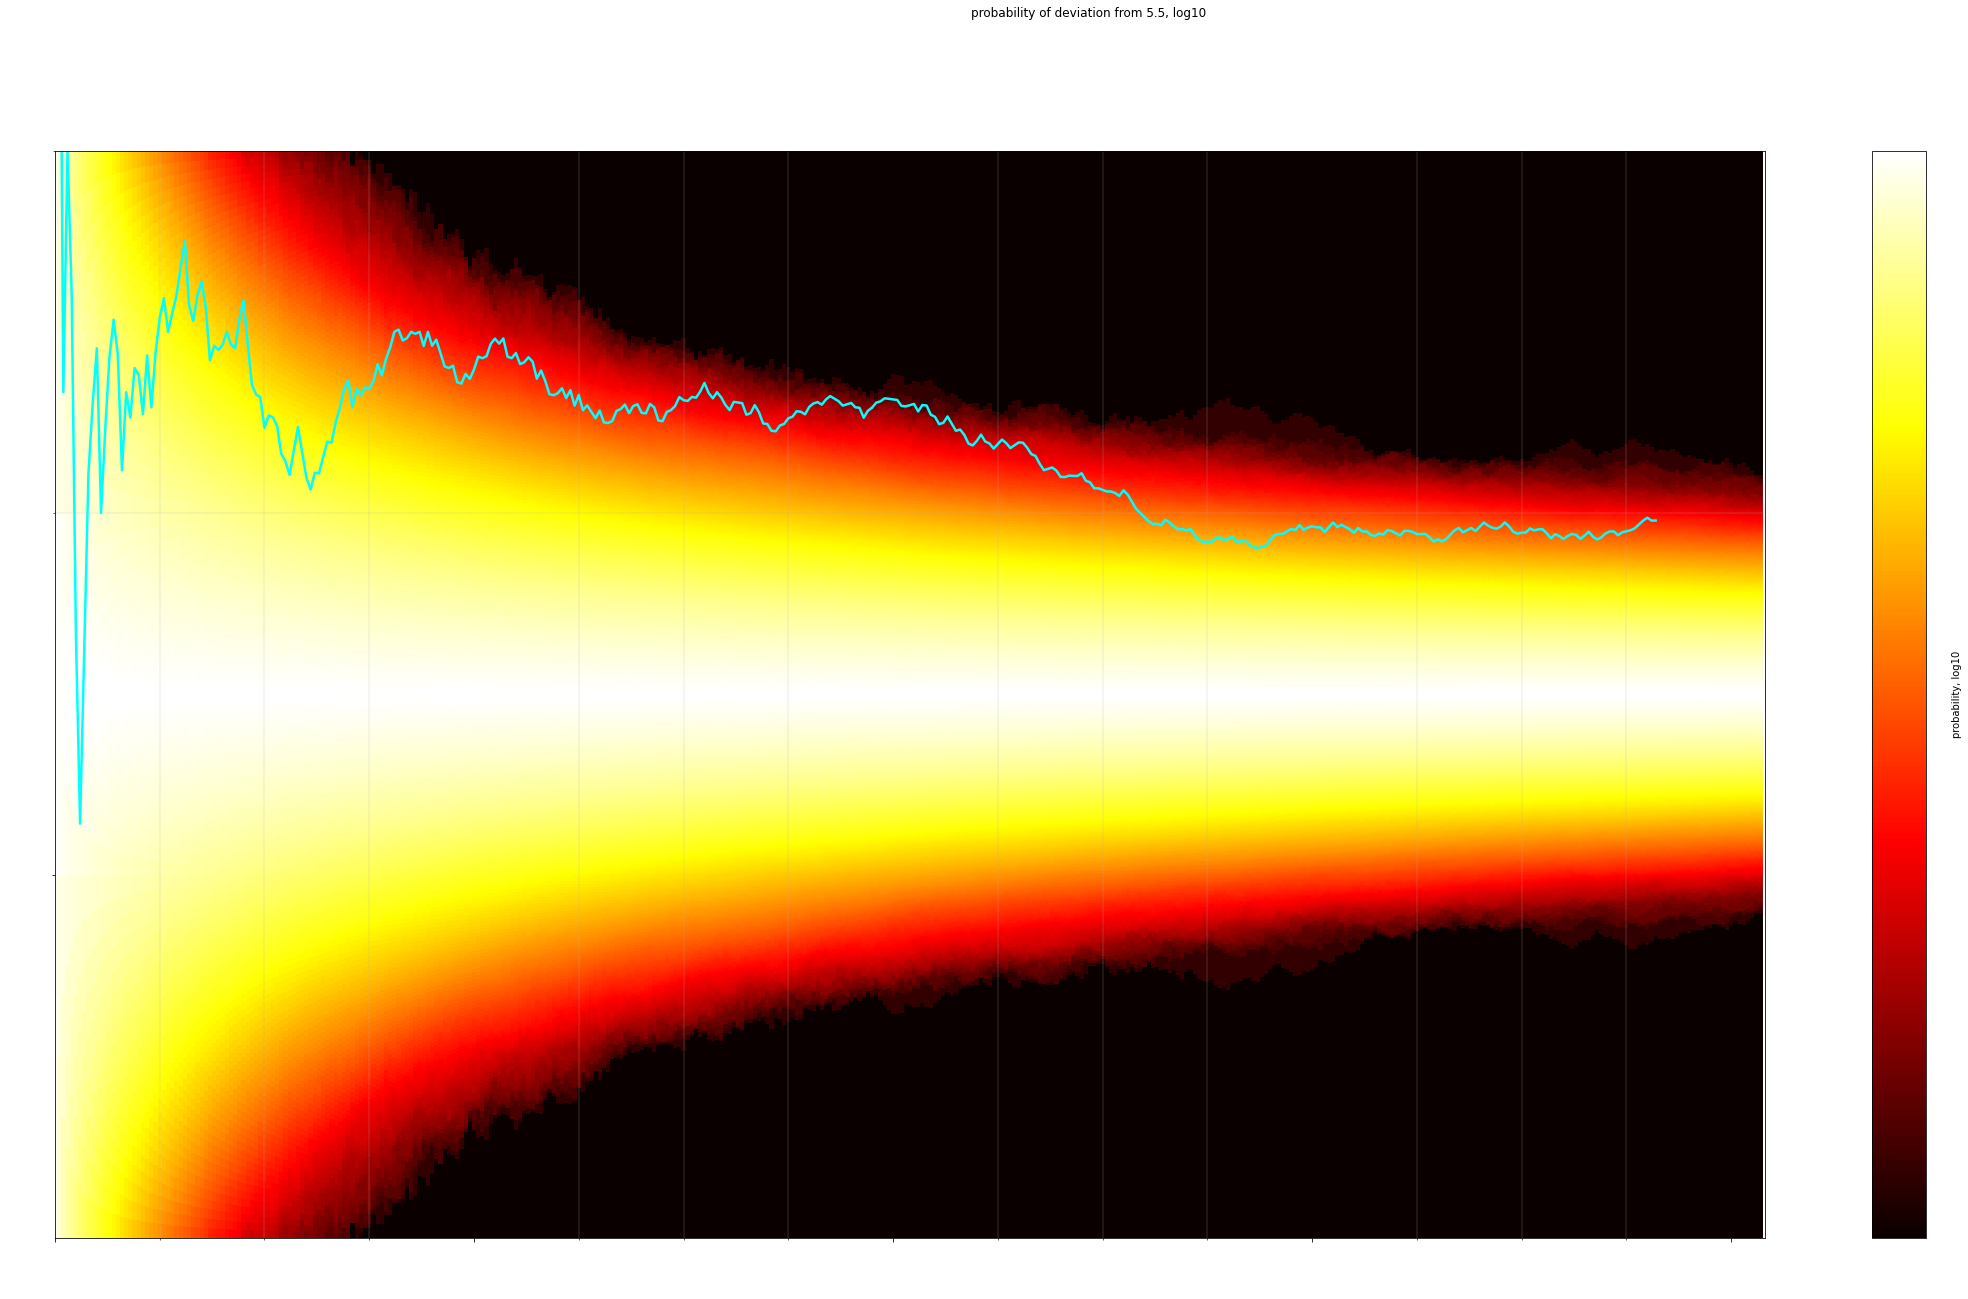

In [6]:
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm

from common.common import (
    read_numbers,
    numbers_to_averages,
    create_histogram,
    normalize_histogram,
)


NUMBERS = read_numbers("data.txt")
AVERAGES = numbers_to_averages(NUMBERS)


DAYS = len(NUMBERS) + 25
ITERS = 100_000
BALLS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
NBINS = 15
PRECISION = 0.0005
SAVE_FILES=False


hist = create_histogram(days=DAYS, iterations=ITERS, balls=BALLS, precision=PRECISION)
normalized_hist = normalize_histogram(hist)
log_hist = np.ma.log10(normalized_hist)
log_hist = log_hist.filled(log_hist.min())

probs = histogram_to_probabilities_of_deviation(hist, precision=PRECISION)
log_probs = np.ma.log10(probs)
log_probs = log_probs.filled(log_probs.min())

xlim=[0, DAYS]
ylim=[4.0, 7.0]
text_color = "white"


fig1, ax1 = plt.subplots(figsize=(len(NUMBERS) / 10, 20))
fig1.suptitle("probability of average, log10")
setup_axis(ax1, xlim, ylim)

cmap1=plt.get_cmap('hot')
line_color1="cyan"
im1 = plot_data(
    data=log_hist, 
    ax=ax1,
    days=DAYS, precision=PRECISION, cmap=cmap1)
ax1.plot(
    np.arange(0, len(NUMBERS), 1),
    AVERAGES,
    color=line_color1,
    linewidth=2.5,
)
setup_colorbar(fig=fig1, im=im1, ax=ax1, plt=plt, text_color=text_color)
plt.show()


fig2, ax2 = plt.subplots(figsize=(len(NUMBERS) / 10, 20))
fig2.suptitle("probability of deviation from 5.5, log10")
setup_axis(ax2, xlim, ylim)

cmap2=plt.get_cmap('hot')
line_color2="cyan"
im2 = plot_data(data=log_probs, ax=ax2, days=DAYS, precision=PRECISION, cmap=cmap2)
ax2.plot(
    np.arange(0, len(NUMBERS), 1),
    AVERAGES,
    color=line_color2,
    linewidth=2.5,
)
setup_colorbar(fig=fig2, im=im2, ax=ax2, plt=plt, text_color=text_color)
plt.show()


if SAVE_FILES:
    image_path="./images"
    Path(image_path).mkdir(exist_ok=True)
    fig1.savefig(f"{image_path}/hit_d{DAYS}_i{ITERS}_p{PRECISION}_{cmap1.name}-{line_color1}.png", facecolor="black")
    fig2.savefig(f"{image_path}/dev_d{DAYS}_i{ITERS}_p{PRECISION}_{cmap2.name}-{line_color1}.png", facecolor="black")